In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import joblib
import numpy as np


In [2]:
conn = sqlite3.connect('database.db')

query = "SELECT time, status, count, day FROM transactions"

transactions = pd.read_sql_query(query, conn)

conn.close()
transactions

,time,status,count,day
0,00h 00,approved,9,1
1,00h 00,denied,6,1
2,00h 00,refunded,1,1
3,00h 01,denied,8,1
4,00h 01,approved,13,1
...,...,...,...,...
8173,23h 57,denied,11,2
8174,23h 58,denied,4,2
8175,23h 58,approved,35,2
8176,23h 59,denied,10,2


In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8178 entries, 0 to 8177
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    8178 non-null   object
 1   status  8178 non-null   object
 2   count   8178 non-null   int64 
 3   day     8178 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 255.7+ KB


In [4]:
status = transactions['status'].unique()

status

array(['approved', 'denied', 'refunded', 'reversed', 'backend_reversed',
       'failed', 'processing'], dtype=object)

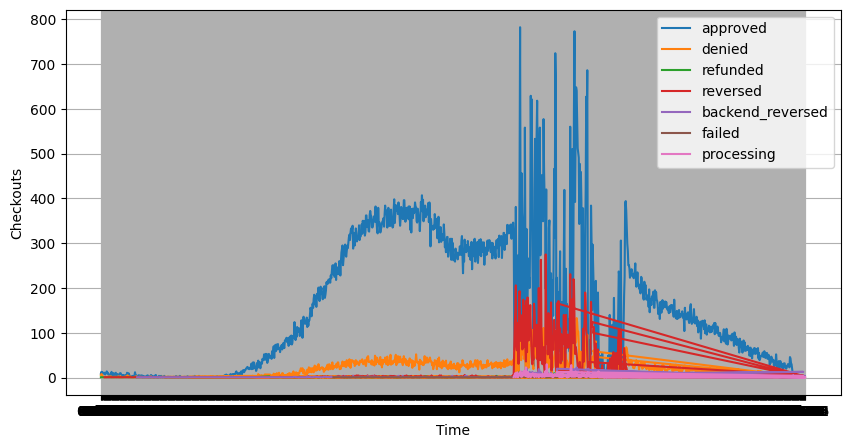

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(transactions[(transactions['status'] == 'approved') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'approved') & (transactions['day'] == 1)]['count'], label='approved')
plt.plot(transactions[(transactions['status'] == 'denied') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'denied') & (transactions['day'] == 1)]['count'], label='denied')
plt.plot(transactions[(transactions['status'] == 'refunded') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'refunded') & (transactions['day'] == 1)]['count'], label='refunded')
plt.plot(transactions[(transactions['status'] == 'reversed') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'reversed') & (transactions['day'] == 1)]['count'], label='reversed')
plt.plot(transactions[(transactions['status'] == 'backend_reversed') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'backend_reversed') & (transactions['day'] == 1)]['count'], label='backend_reversed')
plt.plot(transactions[(transactions['status'] == 'failed') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'failed') & (transactions['day'] == 1)]['count'], label='failed')
plt.plot(transactions[(transactions['status'] == 'processing') & (transactions['day'] == 1)]['time'], transactions[(transactions['status'] == 'processing') & (transactions['day'] == 1)]['count'], label='processing')
plt.xlabel('Time')
plt.ylabel('Checkouts')
plt.legend()
plt.grid(True)
plt.show()

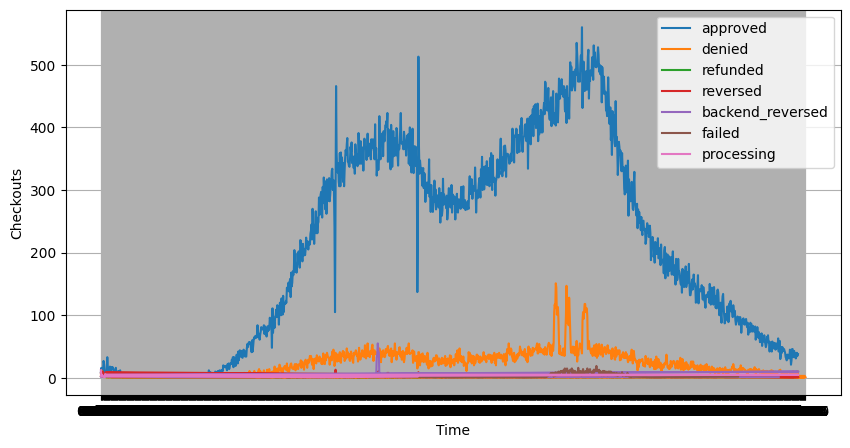

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(transactions[(transactions['status'] == 'approved') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'approved') & (transactions['day'] == 2)]['count'], label='approved')
plt.plot(transactions[(transactions['status'] == 'denied') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'denied') & (transactions['day'] == 2)]['count'], label='denied')
plt.plot(transactions[(transactions['status'] == 'refunded') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'refunded') & (transactions['day'] == 2)]['count'], label='refunded')
plt.plot(transactions[(transactions['status'] == 'reversed') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'reversed') & (transactions['day'] == 2)]['count'], label='reversed')
plt.plot(transactions[(transactions['status'] == 'backend_reversed') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'backend_reversed') & (transactions['day'] == 2)]['count'], label='backend_reversed')
plt.plot(transactions[(transactions['status'] == 'failed') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'failed') & (transactions['day'] == 2)]['count'], label='failed')
plt.plot(transactions[(transactions['status'] == 'processing') & (transactions['day'] == 2)]['time'], transactions[(transactions['status'] == 'processing') & (transactions['day'] == 2)]['count'], label='processing')
plt.xlabel('Time')
plt.ylabel('Checkouts')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
transactions['total_count'] = transactions.groupby(['time', 'day'])['count'].transform('sum')

transactions['percentage'] = (transactions['count'] / transactions['total_count']) * 100

transactions_pivot = transactions.pivot_table(index=['time', 'day'], columns='status', values='percentage', aggfunc='sum', fill_value=0).reset_index()

transactions_pivot

status,time,day,approved,backend_reversed,denied,failed,processing,refunded,reversed
0,00h 00,1,56.250000,0.000000,37.500000,0.0,0.000000,6.250000,0.000000
1,00h 00,2,27.272727,6.060606,9.090909,0.0,36.363636,0.000000,21.212121
2,00h 01,1,61.904762,0.000000,38.095238,0.0,0.000000,0.000000,0.000000
3,00h 01,2,48.484848,3.030303,36.363636,0.0,6.060606,0.000000,6.060606
4,00h 02,1,57.894737,0.000000,36.842105,0.0,0.000000,5.263158,0.000000
...,...,...,...,...,...,...,...,...,...
2636,23h 57,2,78.431373,0.000000,21.568627,0.0,0.000000,0.000000,0.000000
2637,23h 58,1,45.833333,16.666667,12.500000,0.0,12.500000,4.166667,8.333333
2638,23h 58,2,89.743590,0.000000,10.256410,0.0,0.000000,0.000000,0.000000
2639,23h 59,1,38.461538,19.230769,3.846154,0.0,15.384615,0.000000,23.076923


In [8]:
transactions_pivot.describe()

status,day,approved,backend_reversed,denied,failed,processing,refunded,reversed
count,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000
mean,1.499432,84.682959,0.645518,11.210449,0.102156,0.463127,0.250656,2.645135
std,0.500094,16.688971,3.884073,12.190075,0.401005,3.473228,0.958216,7.961343
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,85.365854,0.000000,7.458564,0.000000,0.000000,0.000000,0.000000
50%,1.000000,89.240506,0.000000,9.493671,0.000000,0.000000,0.000000,0.289017
75%,2.000000,91.457286,0.000000,12.020460,0.000000,0.000000,0.268097,0.854701
max,2.000000,100.000000,75.000000,100.000000,3.304348,100.000000,33.333333,59.259259


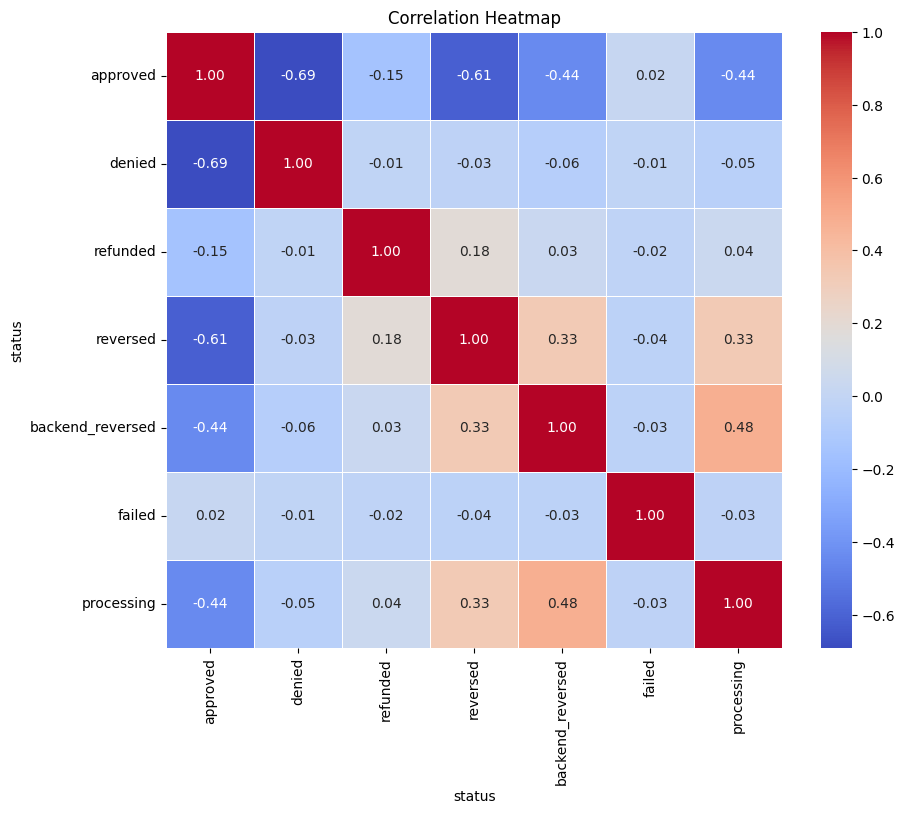

In [9]:
plt.figure(figsize=(10, 8))

sns.heatmap(transactions_pivot[status].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation Heatmap')
plt.show()


In [10]:
iso_forest = IsolationForest(max_samples=100, random_state=0)
iso_forest.fit(transactions_pivot[status])

IsolationForest(max_samples=100, random_state=0)

In [11]:
transactions_pivot['is_anomaly'] = iso_forest.predict(transactions_pivot[status])
transactions_pivot

status,time,day,approved,backend_reversed,denied,failed,processing,refunded,reversed,is_anomaly
0,00h 00,1,56.250000,0.000000,37.500000,0.0,0.000000,6.250000,0.000000,-1
1,00h 00,2,27.272727,6.060606,9.090909,0.0,36.363636,0.000000,21.212121,-1
2,00h 01,1,61.904762,0.000000,38.095238,0.0,0.000000,0.000000,0.000000,1
3,00h 01,2,48.484848,3.030303,36.363636,0.0,6.060606,0.000000,6.060606,-1
4,00h 02,1,57.894737,0.000000,36.842105,0.0,0.000000,5.263158,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...
2636,23h 57,2,78.431373,0.000000,21.568627,0.0,0.000000,0.000000,0.000000,1
2637,23h 58,1,45.833333,16.666667,12.500000,0.0,12.500000,4.166667,8.333333,-1
2638,23h 58,2,89.743590,0.000000,10.256410,0.0,0.000000,0.000000,0.000000,1
2639,23h 59,1,38.461538,19.230769,3.846154,0.0,15.384615,0.000000,23.076923,-1


In [12]:
anomalies = transactions_pivot[transactions_pivot['is_anomaly'] == -1]
anomalies

status,time,day,approved,backend_reversed,denied,failed,processing,refunded,reversed,is_anomaly
0,00h 00,1,56.250000,0.000000,37.500000,0.000000,0.000000,6.250000,0.000000,-1
1,00h 00,2,27.272727,6.060606,9.090909,0.000000,36.363636,0.000000,21.212121,-1
3,00h 01,2,48.484848,3.030303,36.363636,0.000000,6.060606,0.000000,6.060606,-1
4,00h 02,1,57.894737,0.000000,36.842105,0.000000,0.000000,5.263158,0.000000,-1
5,00h 02,2,22.727273,13.636364,18.181818,0.000000,22.727273,0.000000,22.727273,-1
...,...,...,...,...,...,...,...,...,...,...
2011,18h 42,1,78.891821,1.583113,14.775726,0.000000,0.000000,1.319261,3.430079,-1
2422,22h 07,2,92.233010,0.000000,5.825243,1.941748,0.000000,0.000000,0.000000,-1
2555,23h 14,1,80.434783,0.000000,17.391304,2.173913,0.000000,0.000000,0.000000,-1
2637,23h 58,1,45.833333,16.666667,12.500000,0.000000,12.500000,4.166667,8.333333,-1


In [13]:
joblib.dump(iso_forest, 'iso_forest.joblib')

['iso_forest.joblib']